# Model Training
## 1. Data Imports

In [55]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [56]:
# import csv data as pandas dataframe
df = pd.read_csv('data/student_performance.csv')

In [57]:
# show top 5 records
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 2. Preprocessing
### `Math Score` as Our Target Variable

In [58]:
# prep X and y variables
X = df.drop(columns=['math score'], axis=1)
y = df['math score']

X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [59]:
print("Categories in our 'gender' variable:", end=' ')
print(df['gender'].unique())

print("Categories in our 'race/ethnicity' variable:", end=' ')
print(df['race/ethnicity'].unique())

print("Categories in our 'parental level of education' variable:", end=' ')
print(df['parental level of education'].unique())

print("Categories in our 'lunch' variable:", end=' ')
print(df['lunch'].unique())

print("Categories in our 'test preparation course' variable:", end=' ')
print(df['test preparation course'].unique())

Categories in our 'gender' variable: ['female' 'male']
Categories in our 'race/ethnicity' variable: ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in our 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in our 'lunch' variable: ['standard' 'free/reduced']
Categories in our 'test preparation course' variable: ['none' 'completed']


In [60]:
# create Column Transformer with 2 types of transformers
num_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

num_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('StandardScaler', num_transformer, num_features),
        ('OneHoteEncoder', oh_transformer, categorical_features),
    ]
)

X = preprocessor.fit_transform(X)
X.shape

(1000, 19)

In [61]:
# split dataset into train and test sets
X_train, X_placeholder, y_train, y_placeholder = train_test_split(X, y, test_size=0.3, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_placeholder, y_placeholder, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape)

(700, 19) (150, 19)


In [62]:
# evaluation fxn to easily return all metrics after model training
def evaluate_model(true_vals, predicted_vals):
    mae = mean_absolute_error(true_vals, predicted_vals)
    mse = mean_squared_error(true_vals, predicted_vals)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, predicted_vals)
    return mae, rmse, r2

## 3. Train and Predict

In [63]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoosting Regressor': CatBoostRegressor(verbose=False),
    'AdaBoostRegressor': AdaBoostRegressor()
}

model_list = []
r2_list = []

# iterate through each model
for name, model in models.items():
    # train model on the training data
    model.fit(X_train, y_train)

    # make predictions on the training data
    y_train_pred = model.predict(X_train)

    # make predictions on the evaluation data
    y_eval_pred = model.predict(X_eval)

    # evaluate the model on the train data
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    # evaluate the model on the test data
    model_eval_mae, model_eval_rmse, model_eval_r2 = evaluate_model(y_eval, y_eval_pred)

    print(name)
    model_list.append(name)

    print('Model performance for Training Set')
    print(f'-- Root Mean Squred Error: {model_train_rmse:.4f}')
    print(f'-- Mean Absolute Error: {model_train_mae:.4f}')
    print(f'-- R2 Score: {model_train_r2:.4f}')
    print('-'*35)
    
    print('Model performance for Evaluation Set')
    print(f'-- Root Mean Squred Error: {model_eval_rmse:.4f}')
    print(f'-- Mean Absolute Error: {model_eval_mae:.4f}')
    print(f'-- R2 Score: {model_eval_r2:.4f}')
    r2_list.append(model_eval_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training Set
-- Root Mean Squred Error: 5.2483
-- Mean Absolute Error: 4.1985
-- R2 Score: 0.8751
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 5.6664
-- Mean Absolute Error: 4.5172
-- R2 Score: 0.8938


Lasso
Model performance for Training Set
-- Root Mean Squred Error: 6.5106
-- Mean Absolute Error: 5.1582
-- R2 Score: 0.8078
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 7.4174
-- Mean Absolute Error: 5.9252
-- R2 Score: 0.8179


Ridge
Model performance for Training Set
-- Root Mean Squred Error: 5.2487
-- Mean Absolute Error: 4.1977
-- R2 Score: 0.8751
-----------------------------------
Model performance for Evaluation Set
-- Root Mean Squred Error: 5.6708
-- Mean Absolute Error: 4.5186
-- R2 Score: 0.8936


K-Neighbors Regressor
Model performance for Training Set
-- Root Mean Squred Error: 5.6813
-- Mean Absolute Error: 4.5040
-- R2 Sc

## 4. Results

In [64]:
# zip together model_list and r2_list
models_r2 = zip(model_list, r2_list)

# turn into pd df
results = pd.DataFrame(models_r2, columns=['Model Name', 'R2 Score'])

# sort by r2 score
results = results.sort_values(by='R2 Score', ascending=False)
results

,Model Name,R2 Score
0,Linear Regression,0.893751
2,Ridge,0.893587
6,CatBoosting Regressor,0.862769
4,Decision Tree,0.859333
7,AdaBoostRegressor,0.847922
5,XGBoost,0.835730
1,Lasso,0.817943
3,K-Neighbors Regressor,0.782324


#### Insights

- Ridge Regression and Linear Regression have the best test set performance, with an R2 score of 88.06% and 88.04% respectively
- since their performace is so close, we will use Linear Regression for ease of interpretation

### 4.1 Train Final Model on Test Set

In [66]:
# initialize final model
final_model = LinearRegression(fit_intercept=True)

final_X_train = np.vstack((X_train, X_eval))
final_y_train = np.concatenate((y_train, y_eval))

# train final model on train data
final_model.fit(final_X_train, final_y_train)

# predict final model on train data
y_test_pred = final_model.predict(X_test)

# evaluate final model on train data
final_test_mae, final_test_rmse, final_test_r2 = evaluate_model(y_test, y_test_pred)

print('Final Model: Linear Regression')
print('Model Performance for Test Set')
print(f'-- Root Mean Squared Error: {final_test_mae:.4f}')
print(f'-- Mean Absolute Error: {final_test_rmse:.4f}')
print(f'-- R2 Score: {final_test_r2:.4f}')

Final Model: Linear Regression
Model Performance for Test Set
-- Root Mean Squared Error: 4.3284
-- Mean Absolute Error: 5.4387
-- R2 Score: 0.8486


### 4.2 Parity Plot and Regression Plot for Final Model

Text(0, 0.5, 'Predicted')

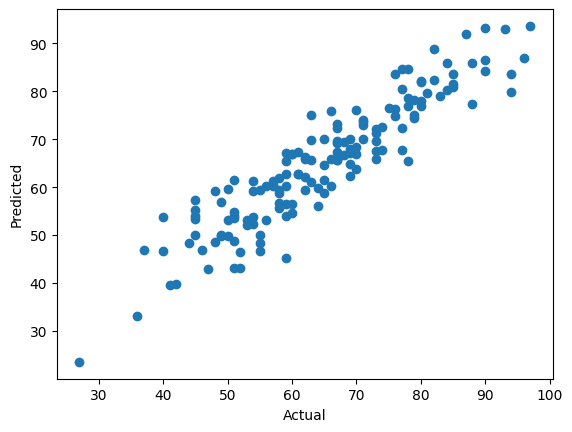

In [67]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

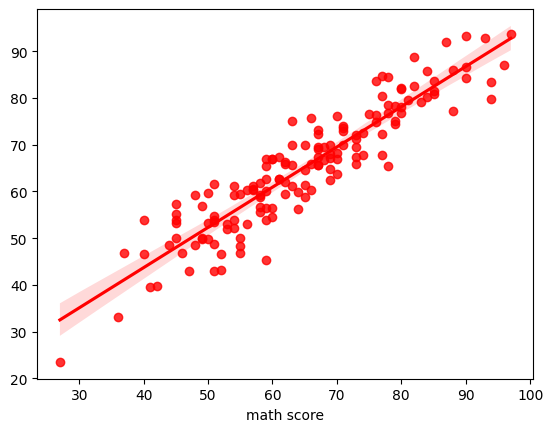

In [76]:
# plot regression line through scatter plot (with 99% confidence interval around the line)
sns.regplot(x=y_test, y=y_test_pred, ci=99 , color='red')

plt.show()

### 4.3 Difference Between Actual and Predicted Values

In [81]:
predicted_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_test_pred,
    'Difference': y_test - y_test_pred,
})

# mean absolute error as a measure of uncertainty
uncertainty_mae = predicted_df['Difference'].abs().mean()
print(f'Uncertainty (MAE): {uncertainty_mae:.2f}')
predicted_df.head()

Uncertainty (MAE): 4.33


,Actual Value,Predicted Value,Difference
557,61,67.347930,-6.347930
798,69,68.026458,0.973542
977,62,66.356259,-4.356259
136,51,48.706080,2.293920
575,40,53.853272,-13.853272
